In [12]:
import os
import pandas as pd
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(torch.__version__)
print(torchvision.__version__)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

True
2.2.0+cu118
0.17.0+cu118


In [13]:
# define annoations and image directories
anno_paths = []
img_dirs = []
anno_base_path = './lisa-traffic-light-dataset/Annotations/Annotations'
img_base_path = './lisa-traffic-light-dataset'

# get all the annotation and image directories
for train_type in ['dayTrain', 'nightTrain']: 
# for train_type in ['dayTrain']:     
    anno_train_path = os.path.join(anno_base_path, train_type)
    img_train_path = os.path.join(img_base_path, train_type, train_type)
    # print("anno_train_path: ", anno_train_path)
    # print("img_train_path: ",img_train_path)

    for clip in os.listdir(anno_train_path):
        clip_path = os.path.join(anno_train_path, clip)
        # print("anno_train_clip_path: ", clip_path)
        
        if os.path.isdir(clip_path):
            # Annotation file path
            anno_file = os.path.join(clip_path, 'frameAnnotationsBULB.csv')
            print("anno_file: ", anno_file)
            if os.path.isfile(anno_file):
                anno_paths.append(anno_file)

    for clip in os.listdir(img_train_path):
        clip_path = os.path.join(img_train_path, clip)
        # print("img_train_clip_path: ", clip_path)
        
        if os.path.isdir(clip_path):
            # Corresponding image directory path
            img_dir = os.path.join(clip_path, 'frames')
            if os.path.isdir(img_dir):
                img_dirs.append(img_dir)
                print("img_dir: ", img_dir)


anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip1\frameAnnotationsBULB.csv
anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip10\frameAnnotationsBULB.csv
anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip11\frameAnnotationsBULB.csv
anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip12\frameAnnotationsBULB.csv
anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip13\frameAnnotationsBULB.csv
anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip2\frameAnnotationsBULB.csv
anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip3\frameAnnotationsBULB.csv
anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip4\frameAnnotationsBULB.csv
anno_file:  ./lisa-traffic-light-dataset/Annotations/Annotations\dayTrain\dayClip5\frameAnnotationsBULB.csv
anno_file:  ./lisa-traff

In [14]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import functional as F

class TrafficLightDataset(Dataset):
    def __init__(self, annotations_files, img_dirs, transform=None):
        # Concatenates all the CSV annotation files into a single pandas DataFrame. 
        # Each file is read with pandas' read_csv, assuming that ; is used as the delimiter.
        self.annotations = pd.concat([pd.read_csv(f, sep=';') for f in annotations_files], ignore_index=True)
        print("The first 3 element in self.annotations\n",self.annotations[0:3])
        
        print("All Unique Annotation tag(labels)\n",self.annotations['Annotation tag'].unique())

        # Defines a mapping from class labels to integers
        self.img_dirs = img_dirs
        self.transform = transform
        self.class_to_idx = {'stop': 0, 
                             'stopLeft': 1, 
                             'go': 2, 
                             'goLeft': 3, 
                             'warningLeft': 4, 
                             'warning': 5} # 6 classes 

    def __len__(self):
        return len(self.annotations)  
    
    def __getitem__(self, idx):
        img_annotations = self.annotations.iloc[idx]

        img_filename = img_annotations['Filename']
        box = img_annotations[['Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y']].values.astype('float')
        label = self.class_to_idx[img_annotations['Annotation tag']]

        # print(img_filename, box, label)

        clip_dir_name = img_filename.split('/')[1].split('--')[0]
        img_dir = next((dir for dir in self.img_dirs if dir.endswith(os.path.join(clip_dir_name, 'frames'))), None)
        if img_dir is None:
            raise FileNotFoundError(f"Image directory for {clip_dir_name} not found.")
        full_img_path = os.path.join(img_dir, img_filename.split('/')[1])
        # Load the image
        image = Image.open(full_img_path).convert("RGB")

        x1, y1, x2, y2 = map(int, box)
        if x2 > x1 and y2 > y1:
            traffic_light_img = image.crop((x1, y1, x2, y2))
            
            # Apply transformations meant for PIL images here
            if self.transform:
                traffic_light_img = self.transform(traffic_light_img)
      
            return traffic_light_img, label
    



In [15]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

dataset = TrafficLightDataset(anno_paths, img_dirs, transform=transform)

# define size of train and validation data
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# split dataset into train and validation sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print("Training dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

def print_dataset_samples(dataset, num_samples=3):
    for i in range(num_samples):
        image, target = dataset[i]
        print(f"Image size: {image.shape}")
        print(f"Target: {target}\n")

print("Train Dataset Samples:")
print_dataset_samples(train_dataset)

print("\nTest Dataset Samples:")
print_dataset_samples(test_dataset)

The first 3 element in self.annotations
                           Filename Annotation tag  Upper left corner X  \
0  dayTraining/dayClip1--00000.jpg             go                  702   
1  dayTraining/dayClip1--00000.jpg             go                  850   
2  dayTraining/dayClip1--00001.jpg             go                  702   

   Upper left corner Y  Lower right corner X  Lower right corner Y  \
0                  351                   706                   356   
1                  405                   854                   409   
2                  351                   706                   355   

                                         Origin file  Origin frame number  \
0  dayTraining/dayClip1/dayClip1Shutter0.000800-G...                    0   
1  dayTraining/dayClip1/dayClip1Shutter0.000800-G...                    0   
2  dayTraining/dayClip1/dayClip1Shutter0.000800-G...                    1   

                                        Origin track  \
0  dayTraining/d

In [16]:
# define dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=0)


print(train_loader, test_loader)

<torch.utils.data.dataloader.DataLoader object at 0x0000020B2F035190> <torch.utils.data.dataloader.DataLoader object at 0x0000020AE2BA4150>


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PlainBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class PlainCNN(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(PlainCNN, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels 
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def plain_cnn34(num_classes=1000):
    return PlainCNN(PlainBlock, [3, 4, 6, 3], num_classes)

cnn34 = plain_cnn34(6)
cnn34.to(device)


PlainCNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): PlainBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): PlainBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


Accuracy of the network on the test images: 98.05539745778789 %


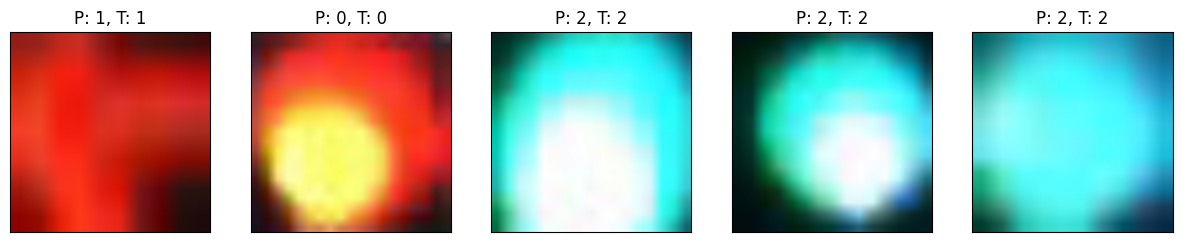

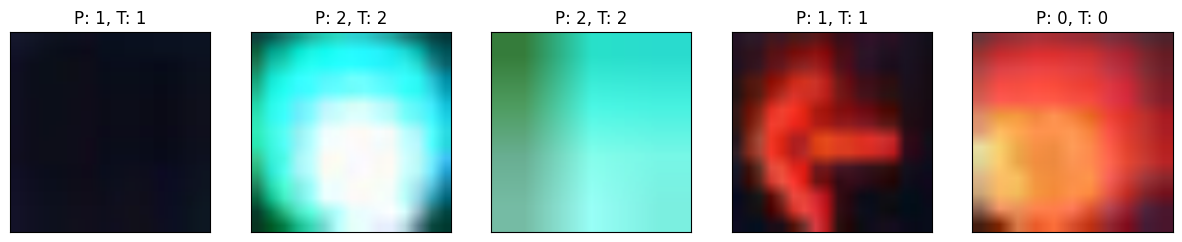

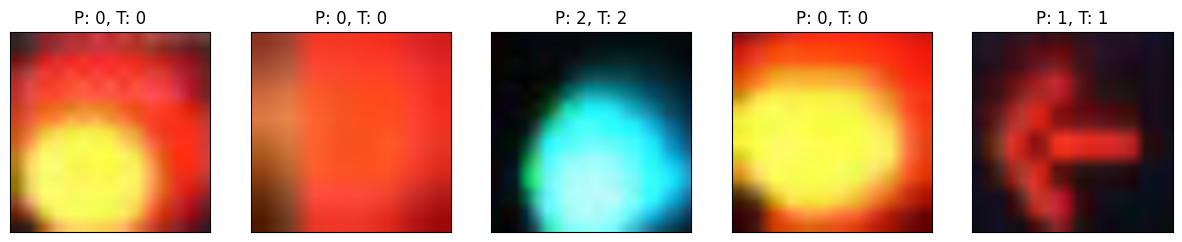

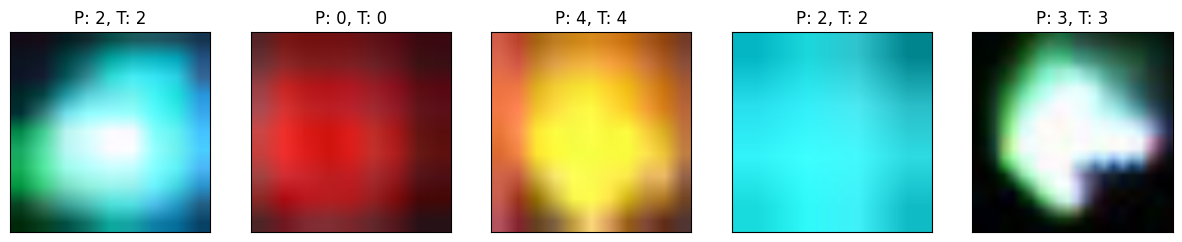

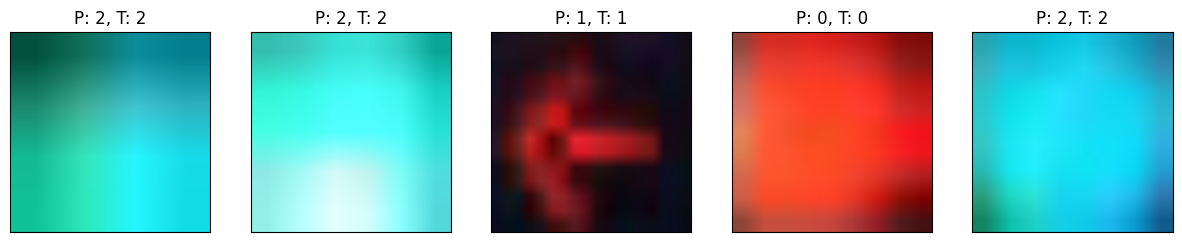

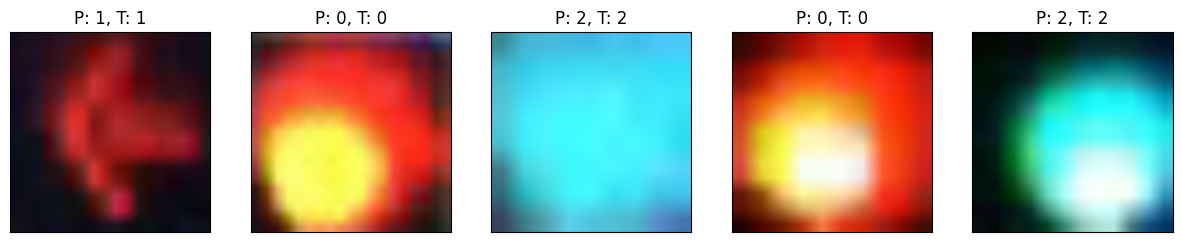

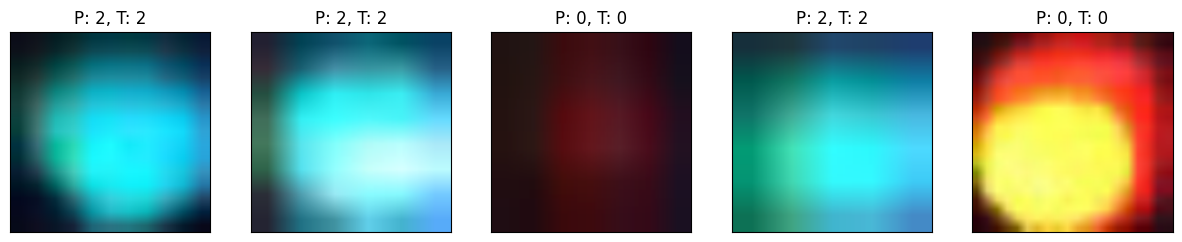

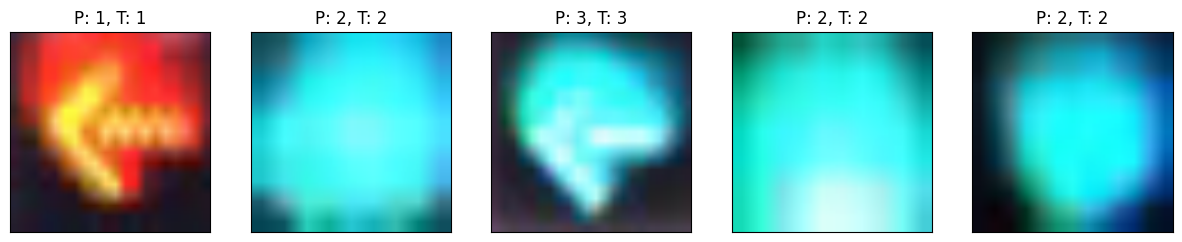

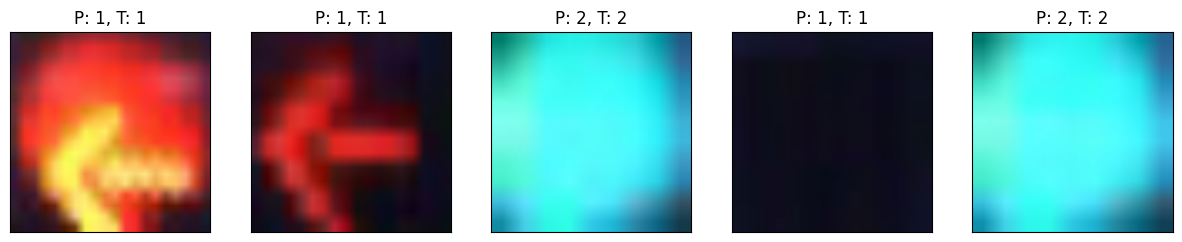

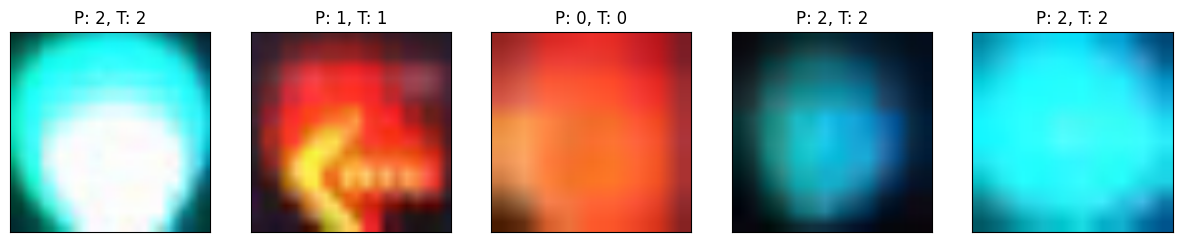

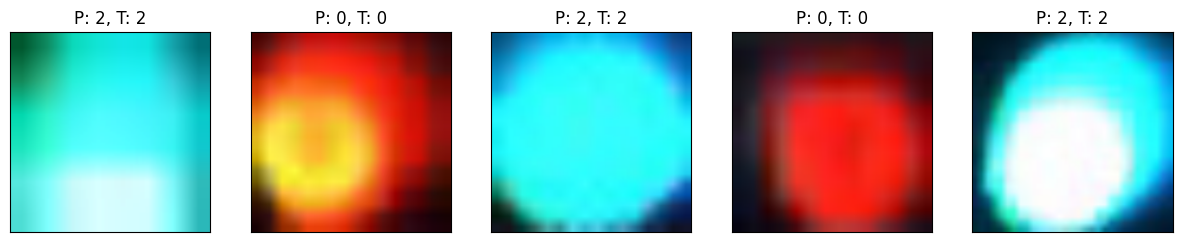

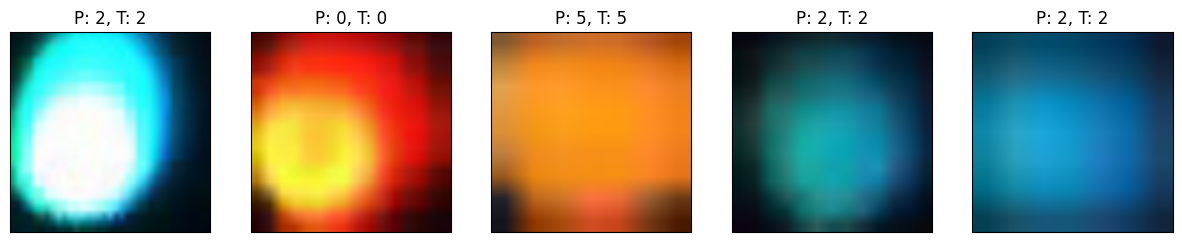

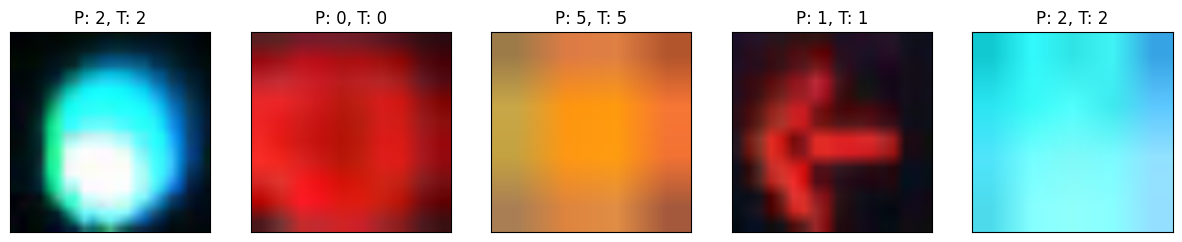

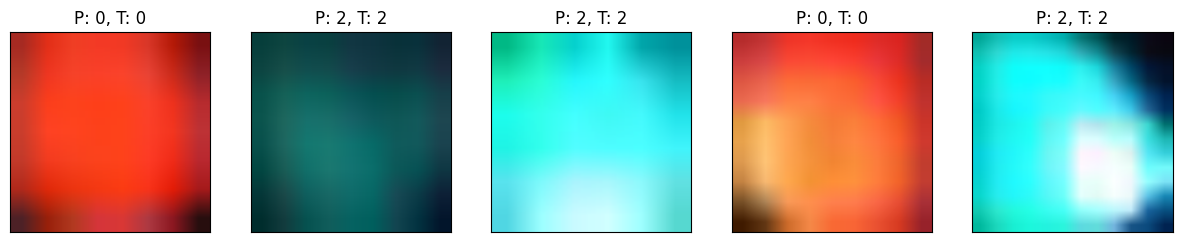

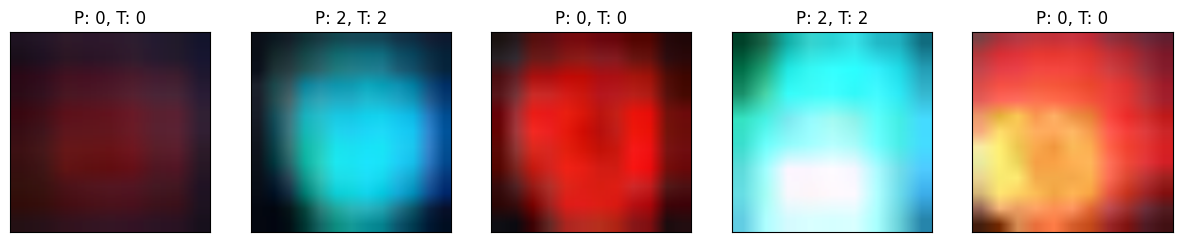

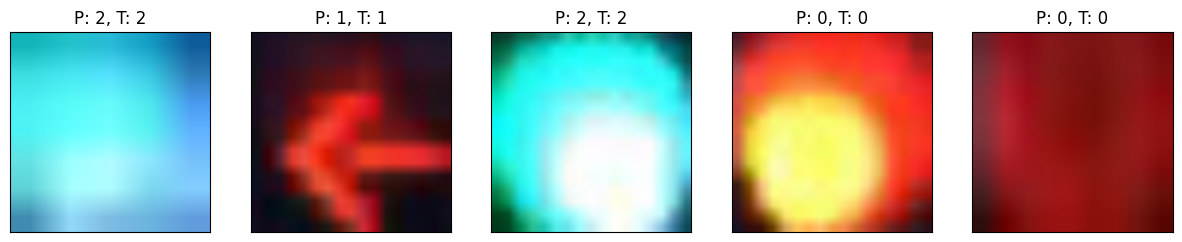

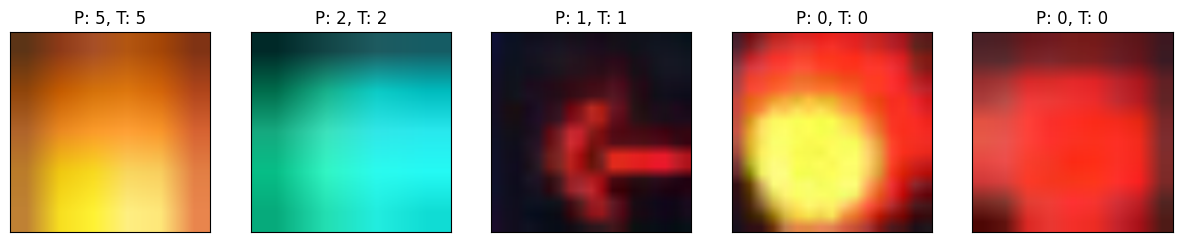

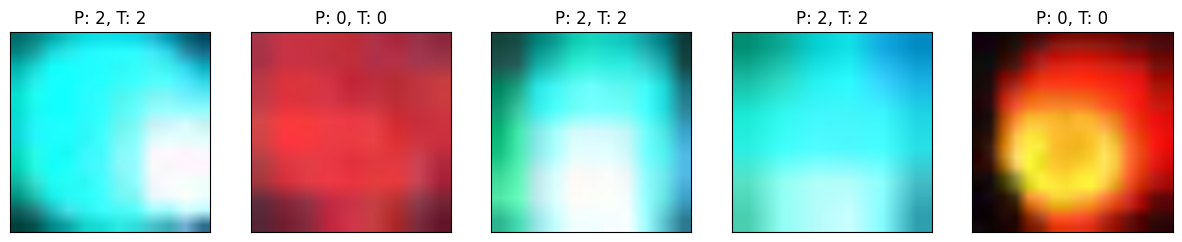

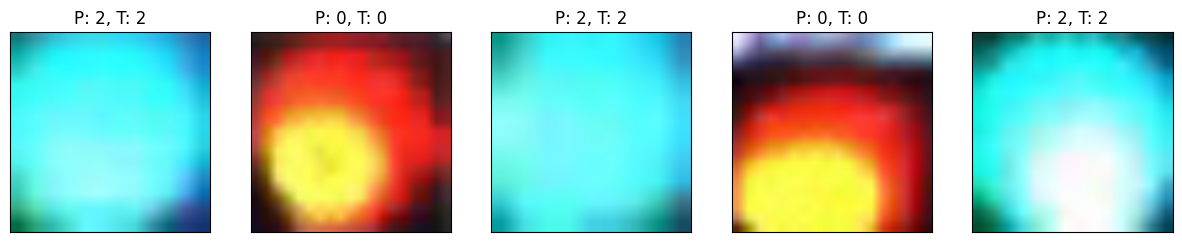

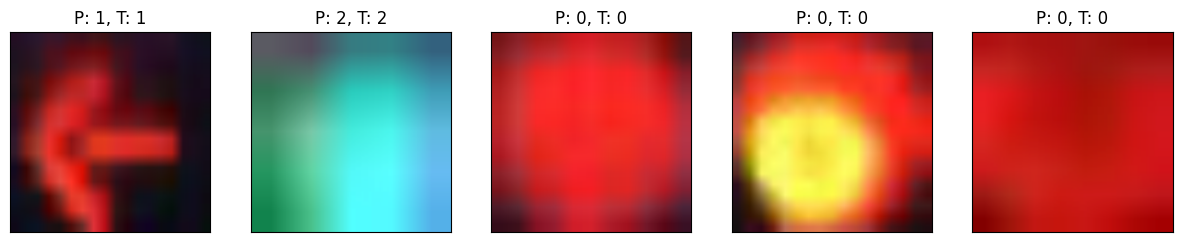

In [19]:
import matplotlib.pyplot as plt

model_path = './plainCNN_epoch10.pth'

cnn34.load_state_dict(torch.load(model_path))
cnn34.to(device)

cnn34.eval()

correct = 0
total = 0

images_list = []
pred_labels = []
true_labels = []

with torch.no_grad(): 
    for images, targets in test_loader:
        images = images.to(device)
        targets = targets.to(device)
        outputs = cnn34(images)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        if len(images_list) < 100:
            images_list.extend(images.cpu())
            pred_labels.extend(predicted.cpu())
            true_labels.extend(targets.cpu())

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy} %')

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  
    img = np.clip(img, 0, 1)
    plt.imshow(img)


num_images = len(images_list)
num_plots = num_images // 5  

for plot_index in range(num_plots):
    fig = plt.figure(figsize=(15, 3)) 
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        img_index = plot_index * 5 + i
        imshow(images_list[img_index])
        ax.set_title(f'P: {pred_labels[img_index].item()}, T: {true_labels[img_index].item()}')
    plt.show()
